# Deep Learning Project - GESTURE RECOGNITION

#### Developed by:
##### 1. Aparna Mehrotra - Group facilitator
##### 2. Pradeep K Sharma


### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# resetting GPU state
!nvidia-smi

Mon Jul 11 02:54:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1D:00.0 Off |                  Off |
| 33%   29C    P8    12W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Data:

In [2]:
# importing data from google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # unzipping files
# !cp '/content/drive/MyDrive/Colab Notebooks/Project_data.zip' '/content'
# !unzip '/content/Project_data.zip' -d '/content/GestureData'

### Importing all necessary Libraries:

In [4]:
# importing libraries
import numpy as np, pandas as pd
import random as rn
import os
from imageio import imread
import tensorflow as tf
from keras import backend as K
import cv2
import matplotlib.pyplot as plt
import datetime
import time

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, GRU
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import mobilenet

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

## Deriving Data Folder Path:


In [6]:
# assigning Train and Validation Path variables
# data_folder = 'GestureData/Project_data'
data_folder='/home/datasets/Project_data'
train_path = data_folder + '/train'
val_path = data_folder + '/val'

num_frames = 30
classes_gestures = 5
trial_count = 1

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open(data_folder + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_folder + '/val.csv').readlines())
batch_size = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def fetch_batch_data(source_path, folder_list, batch_size, num_gesture_frames, image_size, num_channels, batch, img_idx, t) :
   # num_gesture_frames is the number of images you use for each video, (image_size,image_size) is the final size of the input images and 3 is the number of channels RGB
  batch_data = np.zeros((batch_size, num_gesture_frames, image_size, image_size, num_channels))
  
  # batch_labels is the one hot representation of the output
  batch_labels = np.zeros((batch_size, classes_gestures))
  
  # iterate over batch_size
  for folder in range(batch_size):
      gesture_inf_array = t[folder + batch * batch_size].strip().split(';')            
      imgs = os.listdir(source_path+'/'+ gesture_inf_array[0]) # read all the images in the folder
      for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
          # for coloured images
          if num_channels == 3 :
            image = imread(source_path + '/' + gesture_inf_array[0] +'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = cv2.resize(image, (image_size, image_size))

            batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0  #normalise and feed in the image
          # for greyscale images
          else :
            image = cv2.imread(source_path + '/' + gesture_inf_array[0] +'/'+imgs[item], cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_size, image_size))
            batch_data[folder,idx,:,:,0] = image / 255.0

      batch_labels[folder, int(gesture_inf_array[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [9]:
def generator(source_path, folder_list, batch_size, num_frames_selected, image_size, num_channels):
    img_idx =  np.round(np.linspace(0, num_frames - 1, num_frames_selected)).astype(int) #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches =  len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield fetch_batch_data(source_path, folder_list, batch_size, num_frames_selected, image_size, num_channels, batch, img_idx, t)
        
        # write the code for the remaining data points which are left after full batches

        rem_batch_size = len(t) % batch_size
        yield fetch_batch_data(source_path, folder_list, rem_batch_size, num_frames_selected, image_size, num_channels, num_batches, img_idx, t)



In [10]:
# func to plot the train/validation accuracies and losses
def plot_train_val_accuracy_loss_graph(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    # losses subplot
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    # accuracies subplot
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.show()

### Model Function:

In [11]:
def build_model(model_text, model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate=0.001) :
  # Adam optimizer
  optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  # print (model.summary())

  # train generator
  train_generator = generator(train_path, train_doc, batch_size, num_gesture_frames, image_size, num_channels)
  # val generator
  val_generator = generator(val_path, val_doc, batch_size, num_gesture_frames, image_size, num_channels)

  num_train_sequences = len(train_doc) 
  num_val_sequences = len(val_doc) 

  if (num_train_sequences % batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  model_name = model_text + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
      
  if not os.path.exists(model_name):
      os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  # saving best only model
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
  LR = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, verbose = 0, patience = 4)
  callbacks_list = [checkpoint, LR] 

  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=0, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  
  plot_train_val_accuracy_loss_graph(history)
  return history

### Model Memory function:

In [12]:
# functiong to get memory usage by the model
def get_model_memory_usg(batch_size, model):
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usg(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    mbs = np.round(total_memory / (1024.0 ** 2), 3) + internal_model_mem_count
    return mbs

### Model:
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Using Conv_3D :

In [13]:
def model_cnn3d_only(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons) :
  model = Sequential()
  model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(num_gesture_frames,image_size,image_size,num_channels)))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(32, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(64, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(128, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Flatten())
  model.add(Dense(dense_neurons,activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(dense_neurons // 2,activation='relu'))
  if batch_normalize:
    model.add(BatchNormalization())   
  model.add(Dropout(dropout))

  model.add(Dense(classes_gestures,activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("Conv3d_only", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate),model

### Model - 1

2022-07-11 02:54:06.437832: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-11 02:54:06.437906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Total params: 357,541


2022-07-11 02:54:09.037280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


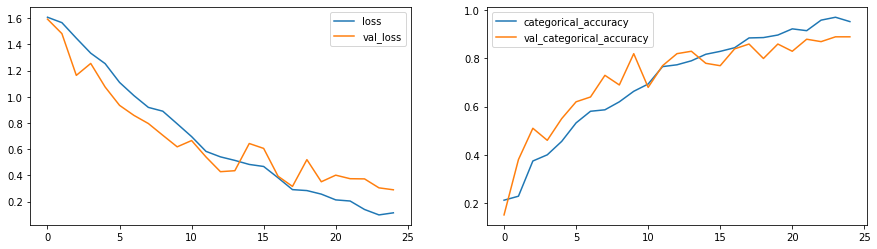

Execution time(in secs):  819.8963952064514 Memory usage(in MB):  632.346
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
24  0.114151              0.953243   0.28994                      0.89  0.0002


In [14]:
# Using batch_size=30, num_epochs=25, num_gesture_frames=30, image_size= 64, num_channels=1, batch_normalize= False, learning_rate= 0.001, dropout= 0.25, dense_neurons= 128
st = time.time()
batch_size=30
hist,model = model_cnn3d_only(batch_size=30, num_epochs=25, num_gesture_frames=30,
                                   image_size= 64, num_channels=1, batch_normalize= False,
                                   learning_rate= 0.001, dropout= 0.25, dense_neurons= 128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 2

Total params: 2,218,501


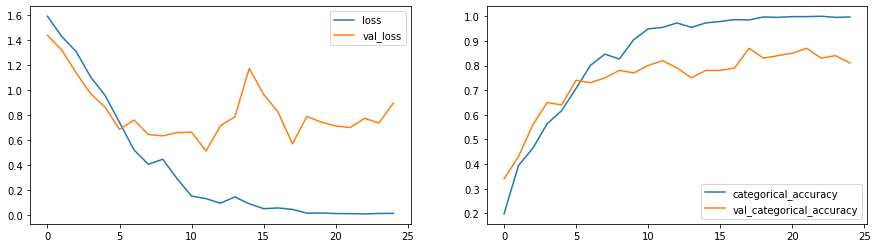

Execution time(in secs):  1615.5036766529083 Memory usage(in MB):  2532.301
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
11  0.129787              0.954751  0.511889                      0.82  0.001


In [15]:
st = time.time()
hist,model = model_cnn3d_only(batch_size= 30, num_epochs= 25, num_gesture_frames= 30,
                                   image_size= 128, num_channels= 3, batch_normalize= False,
                                   learning_rate= 0.001, dropout= 0.25, dense_neurons= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### Model - 3

Total params: 645,637


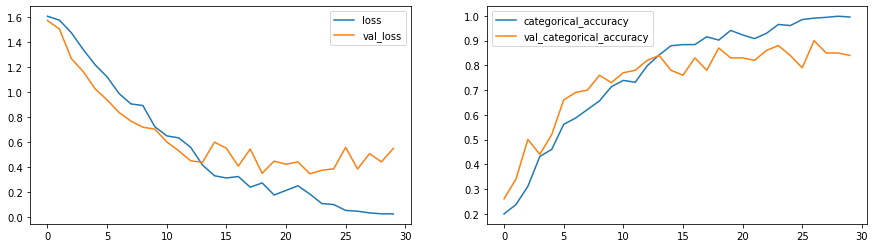

Execution time(in secs):  916.0846064090729 Memory usage(in MB):  341.458
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
22  0.182186               0.92911  0.344087                      0.86  0.0005


In [16]:
st = time.time()
hist,model = model_cnn3d_only(batch_size= 30, num_epochs= 30, num_gesture_frames= 16,
                                   image_size= 64, num_channels= 3, batch_normalize= False,
                                   learning_rate= 0.0005, dropout=0.25, dense_neurons=256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### Model - 4

Total params: 357,797


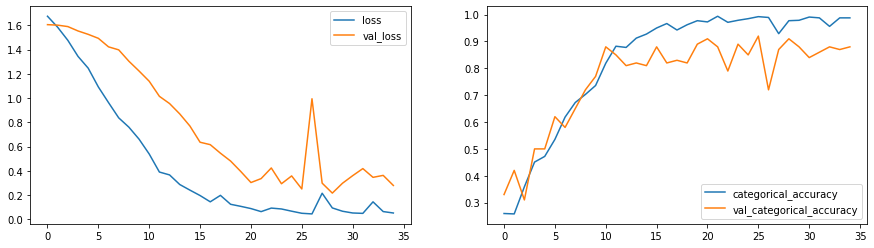

Execution time(in secs):  1214.0217492580414 Memory usage(in MB):  632.354
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
28  0.093485              0.977376  0.215728                      0.91  0.0005


In [17]:
st = time.time()
batch_size= 30
hist,model = model_cnn3d_only(batch_size= 30, num_epochs=35, num_gesture_frames= 30,
                                   image_size= 64, num_channels=1, batch_normalize=True,
                                   learning_rate= 0.0005, dropout= 0.35, dense_neurons=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### CNN_LSTM function:

In [18]:
def model_cnn_lstm(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons, rnn_cells) :
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                            input_shape=(num_gesture_frames, image_size, image_size, num_channels)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
  model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
  model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
  model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(rnn_cells))
  
  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(classes_gestures, activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn_lstm", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate), model

### Model - 5

Total params: 680,357


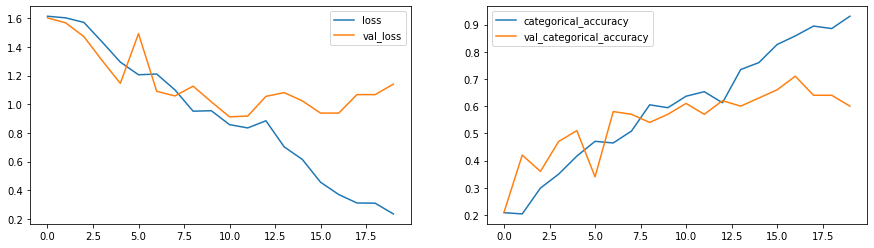

Execution time(in secs):  2384.8572273254395 Memory usage(in MB):  551.07
Best model stats: 
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
10  0.85773              0.636501   0.91213                      0.61  0.001


In [19]:
hist,model = model_cnn_lstm(batch_size=30, num_epochs=20, num_gesture_frames= 30,
                                      image_size=64, num_channels=3, batch_normalize=False,
                                      learning_rate=.001, dropout=0.25, dense_neurons=128, rnn_cells=64)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best model stats: ")
print(df_best)

 

### Model - 6

Total params: 2,572,677


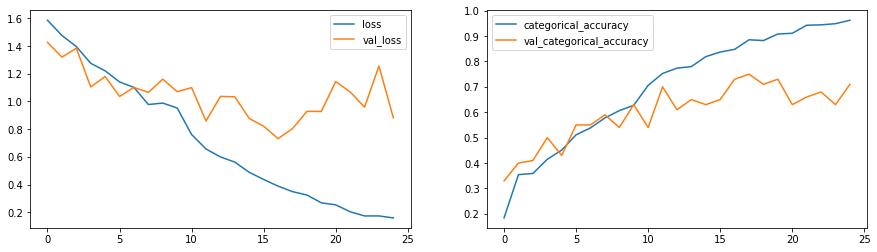

Execution time(in secs):  3355.69930934906 Memory usage(in MB):  2934.873
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
16  0.388387              0.847662  0.731411                      0.73  0.0002


In [20]:
batch_size=40
hist,model = model_cnn_lstm(batch_size=40, num_epochs=25, num_gesture_frames=30,
                                      image_size=128 ,num_channels=1, batch_normalize=False,
                                      learning_rate= 0.001, dropout=0.25, dense_neurons=128, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)

 

### Model - 7

Total params: 4,916,869


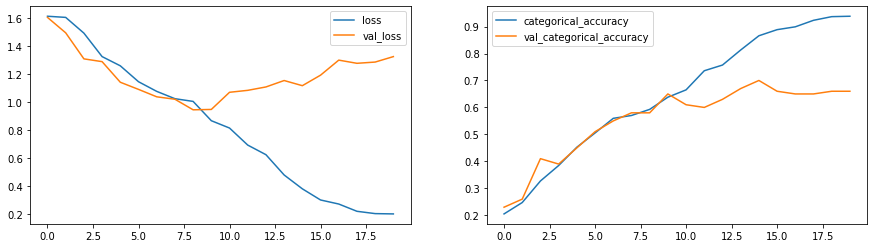

Execution time(in secs):  4128.599784851074 Memory usage(in MB):  2177.918
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
8  1.003393               0.59276  0.943381                      0.58  0.001


In [21]:
batch_size=25
hist,model = model_cnn_lstm(batch_size=25, num_epochs=20, num_gesture_frames=30,
                                      image_size=140, num_channels=1, batch_normalize=False,
                                      learning_rate=0.001, dropout= 0.25, dense_neurons= 256, rnn_cells= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)

 

### Model - 8

Total params: 1,838,501


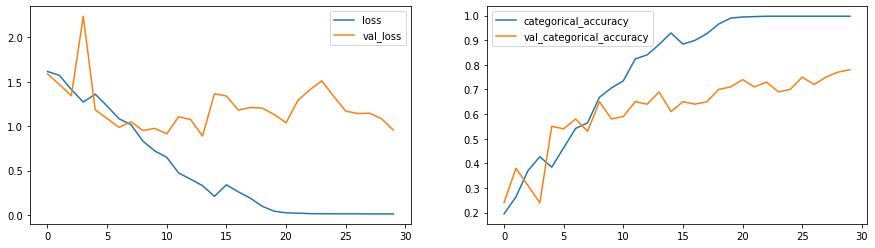

Execution time(in secs):  5887.482131719589 Memory usage(in MB):  555.598
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
13  0.32995              0.882353  0.890042                      0.69  0.001


In [22]:
batch_size= 30
hist,model = model_cnn_lstm(batch_size= 30, num_epochs= 30, num_gesture_frames= 30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 512, rnn_cells= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)

 

### CNN_GRU function:

In [23]:
def model_cnn_GRU(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons, rnn_cells) :
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                            input_shape=(num_gesture_frames, image_size, image_size, num_channels)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
  model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
  model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  
  model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(GRU(rnn_cells))
  
  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(classes_gestures, activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn_gru", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate), model

### Model - 9

Total params: 852,901


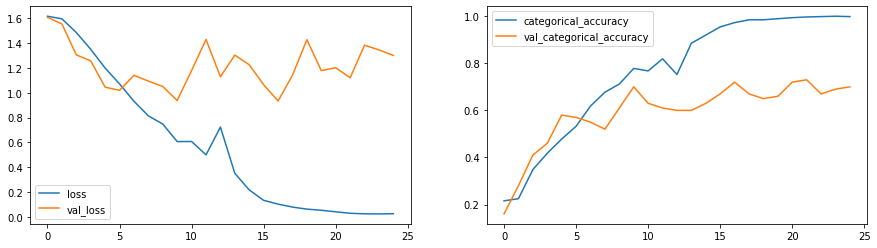

Execution time(in secs):  7329.976033687592 Memory usage(in MB):  551.736
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
16  0.104046              0.972851  0.933167                      0.72  0.0002


In [24]:
hist,model = model_cnn_GRU(batch_size=30, num_epochs=25, num_gesture_frames=30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 128, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 10

Total params: 2,049,413


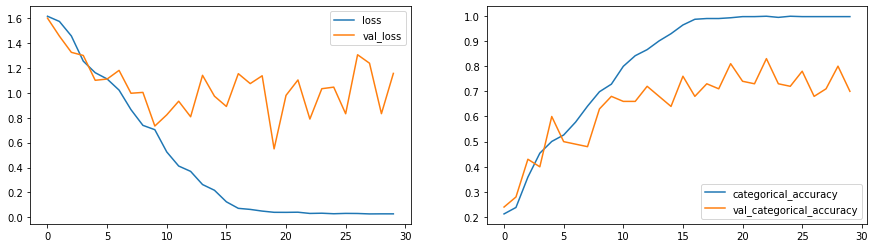

Execution time(in secs):  8491.955808639526 Memory usage(in MB):  2932.916
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
19  0.039666              0.992459  0.549912                      0.81   

         lr  
19  0.00004  


In [25]:
batch_size= 40
hist,model = model_cnn_GRU(batch_size= 40, num_epochs=30, num_gesture_frames=30,
                                      image_size= 128, num_channels= 1, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 256, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 11

Total params: 1,444,261


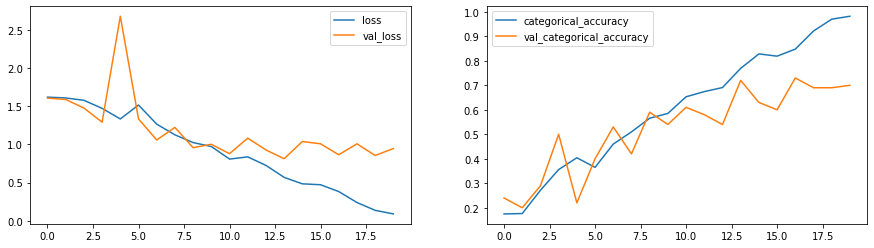

Execution time(in secs):  9647.36706829071 Memory usage(in MB):  554.035
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
13  0.568773              0.769231  0.812777                      0.72  0.001


In [26]:
batch_size= 30
hist,model = model_cnn_GRU(batch_size= 30, num_epochs= 20, num_gesture_frames=30,
                                      image_size= 64, num_channels=3, batch_normalize=False,
                                      learning_rate= 0.001, dropout = 0.25, dense_neurons= 256, rnn_cells=256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 12

---



---



Total params: 1,395,589


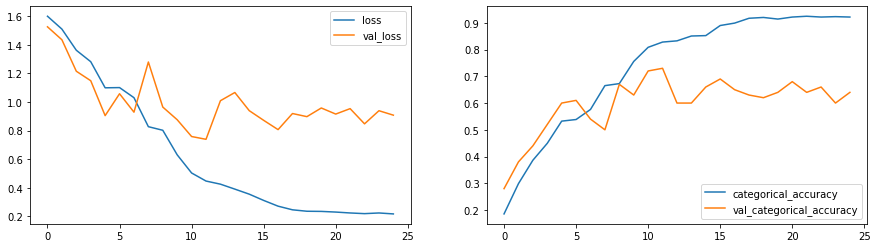

Execution time(in secs):  10556.562777519226 Memory usage(in MB):  1772.834
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
11  0.44664              0.828054  0.738557                      0.73  0.0002


In [27]:
batch_size=40
hist,model = model_cnn_GRU(batch_size=40, num_epochs=25, num_gesture_frames= 30,
                                      image_size=100, num_channels=1, batch_normalize=False,
                                      learning_rate=0.001, dropout= 0.25, dense_neurons=512, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### FINAL MODEL:

We selected Conv3D model#1 as the best performing model over CNN+LSTM and CNN+GRU for following reasons:
- Training Accuracy :	95%
- Validation Accuracy:	89%
- Number of parameters are low 357,541 which makes the model computationally less expensive
- Model is Statistically simpler.

